# Weighted K-Means clustering for the Boundery Layer Case

As seen in the ```K_Means_BL``` notebook, due to K-Means clustering relying solely on the euclidean distance between points and their distribution in the equation space, only a subset of the dominant balance regimes were identified (viscous sublayer, laminar inflow, transitional region), and this over-simplifies the flow's dominant balance regions.

Here, a weighted K-Means algorithm is used, where weights are defined as a function of the points' distance from the origin.

Again, the preprocessing carried out is the same:

In [1]:
import numpy as np
from numpy.random import randint
import h5py
import matplotlib.pyplot as plt
import sys
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.decomposition import SparsePCA
from scipy.io import loadmat
from scipy import sparse, linalg
from scipy.optimize import curve_fit, root
from scipy.integrate import odeint
from scipy.interpolate import interp1d


# adding Tools to the system path
sys.path.insert(0, "../Tools/")
import plot_funcs as pf
import blasius_solution as bs
import preprocessing as pp

import matplotlib as mpl

# 1. Preprocessing

## a. Load the data

In [2]:
# Load the data from http://turbulence.pha.jhu.edu/Transition_bl.aspx
file = h5py.File("../Data/Transition_BL_Time_Averaged_Profiles.h5", "r")

In [3]:
# Get arrays for variables and the Reynold's averages
x = np.array(file["x_coor"])
y = np.array(file["y_coor"])
u = np.array(file["um"])
v = np.array(file["vm"])
p = np.array(file["pm"])
Ruu = np.array(file["uum"]) - u**2
Ruv = np.array(file["uvm"]) - u * v
Rvv = np.array(file["uvm"]) - v**2

In [4]:
# Visualize by wall-normal Reynolds stress
X, Y = np.meshgrid(x, y)

# Include line of 99% of free flow mean velocity
# Values from http://turbulence.pha.jhu.edu/docs/README-transition_bl.pdf
U_inf = 1
nu = 1 / 800
Re = (U_inf / nu) * x

## b. Get the finite difference derivatives to estimate the gradients

__NOTE: VARIABLE STEP SIZE IN Y DIRECTION ONLY__

In [5]:
# Get space steps

dx = x[1] - x[0]
dy = y[1:] - y[:-1]

nx = len(x)  # Number of points in x
ny = len(y)  # Number of points in y

# Compute the derivatives
Dx, Dy = pp.get_derivatives(nx, ny, dx, dy)

Dxx = 2 * (Dx @ Dx)
Dyy = 2 * (Dy @ Dy)

In [6]:
# Flatten arrays for matrix multiplication, using fortran ordering
u = u.flatten("F")
v = v.flatten("F")
p = p.flatten("F")
Ruu = Ruu.flatten("F")
Ruv = Ruv.flatten("F")

# Get derivatives
ux = Dx @ u
uy = Dy @ u
vx = Dx @ v
vy = Dy @ v
px = Dx @ p
py = Dy @ p
lap_u = (Dxx + Dyy) @ u
Ruux = Dx @ Ruu
Ruvy = Dy @ Ruv

## c. Equation space representation

In [7]:
# Labels of terms in the RANS equation
labels = [
    r"$\bar{u} \bar{u}_x$",
    r"$\bar{v}\bar{u}_y$",
    r"$\rho^{-1} \bar{p}_x$",
    r"$\nu \nabla^2 \bar{u}$",
    r"$\overline{(u^\prime v^\prime)}_y$",
    r"$\overline{({u^\prime} ^2)}_x$",
]

In [8]:
# Get terms stored as features
features = 1e3 * np.vstack([u * ux, v * uy, px, nu * lap_u, Ruvy, Ruux]).T
nfeatures = features.shape[1]

# 2. Weighted K-Means 

Now, the weighted K-Means model is trained on a subset of the data with weights applied. The weights are defined as a function of the point's distance from the origin, and using the tanh() function:

$w = 1 - (\text{tanh}^{2}(\frac{1}{2}|\vec{OX}|))$

where $|\vec{OX}|$ is the point-origin distance.

These weights are between 0 and 1, and give more importance to points closer to the origin (e.g. plot below). This is so that the K-Means algorithm is encouraged to cluster points near the origin into separate groups.

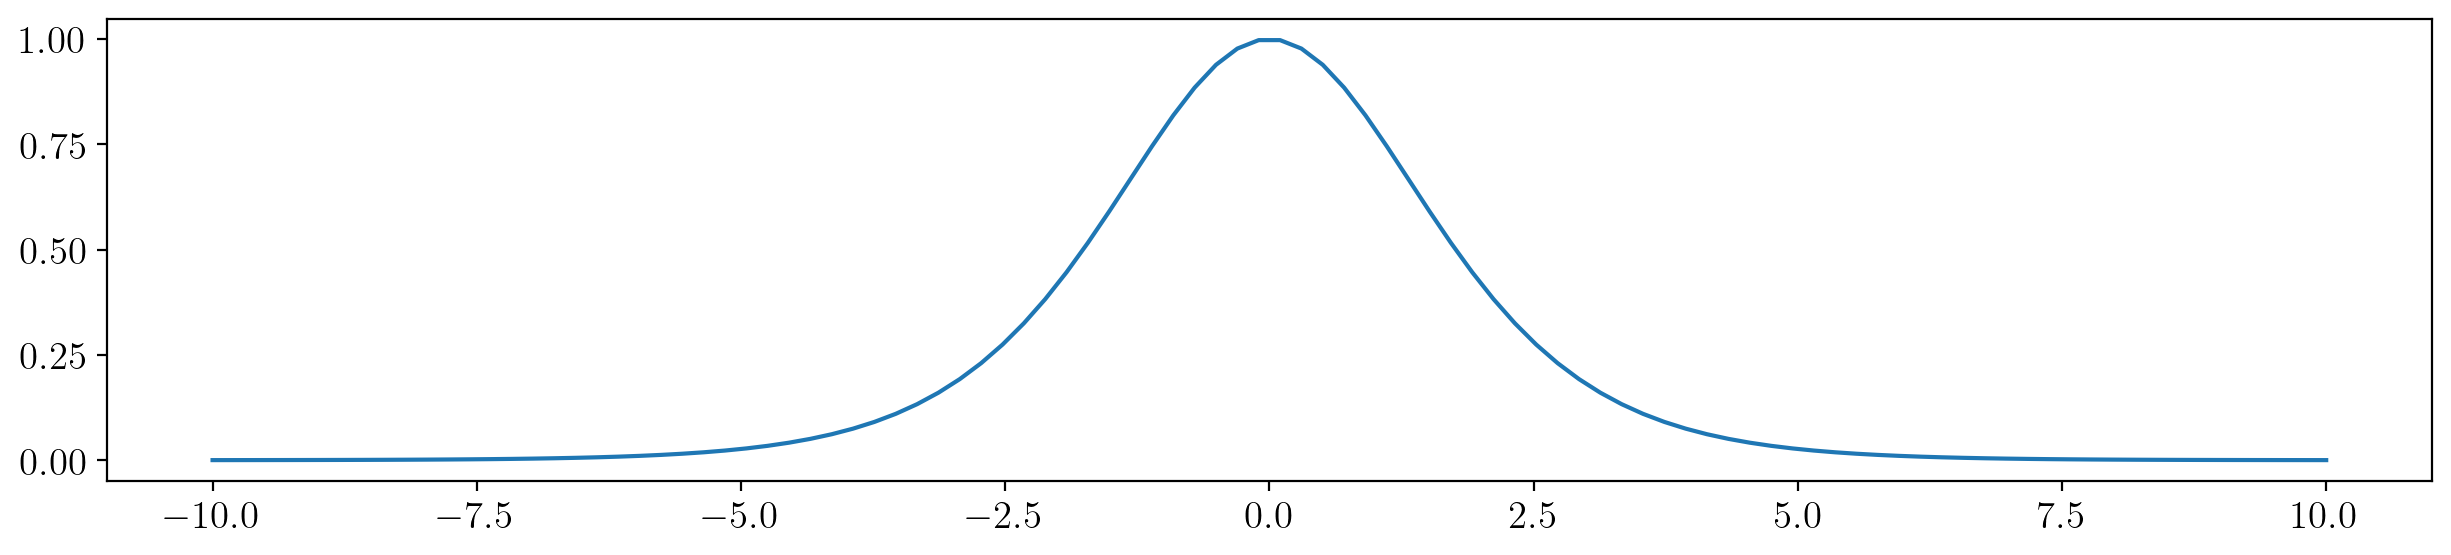

In [9]:
ox = np.linspace(-10, 10, 100)
plt.plot(ox, 1 - (np.tanh((1 / 2) * ox)) ** 2)
plt.show()

## a. Train the model and predict for full dataset

In [10]:
# Train K-means model

# Gather the terms into an array of features
features = 1e3 * np.vstack([u * ux, v * uy, px, nu * lap_u, Ruvy, Ruux]).T
nfeatures = features.shape[1]

# Fit Gaussian mixture model
nc = 6  # Number of clusters
seed = 75016  #  Set a seed for debugging/plotting
np.random.seed(seed)


model = KMeans(n_clusters=nc, random_state=seed)

# Train on only a subset (10%) of the data
sample_pct = 0.2
mask = np.random.permutation(features.shape[0])[: int(sample_pct * features.shape[0])]

In [11]:
# Set tanh sample weights
origin_dist_mask = np.linalg.norm(features[mask, :], axis=1)
sample_weights_mask = 1 - (np.tanh((1) * origin_dist_mask)) ** 2

# Fit the model
model.fit(features[mask, :], sample_weight=sample_weights_mask)

KMeans(n_clusters=6, random_state=75016)

In [12]:
# Predict clusters for all data
origin_dist = np.linalg.norm(features, axis=1)
sample_weights = 1 - (np.tanh((1) * origin_dist)) ** 2

# Predict clusters
clustering = model.predict(features, sample_weight=sample_weights)

# Get covariances in each cluster
covs = np.zeros((nc, nfeatures, nfeatures))
for i in range(nc):
    mask_ = clustering == i
    covs[i, :, :] = np.cov(features[mask_, :].T)

/Users/thomasbreitburd/anaconda3/envs/Project_24/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1102: FutureWarning: 'sample_weight' was deprecated in version 1.3 and will be removed in 1.5.
  warnings.warn(


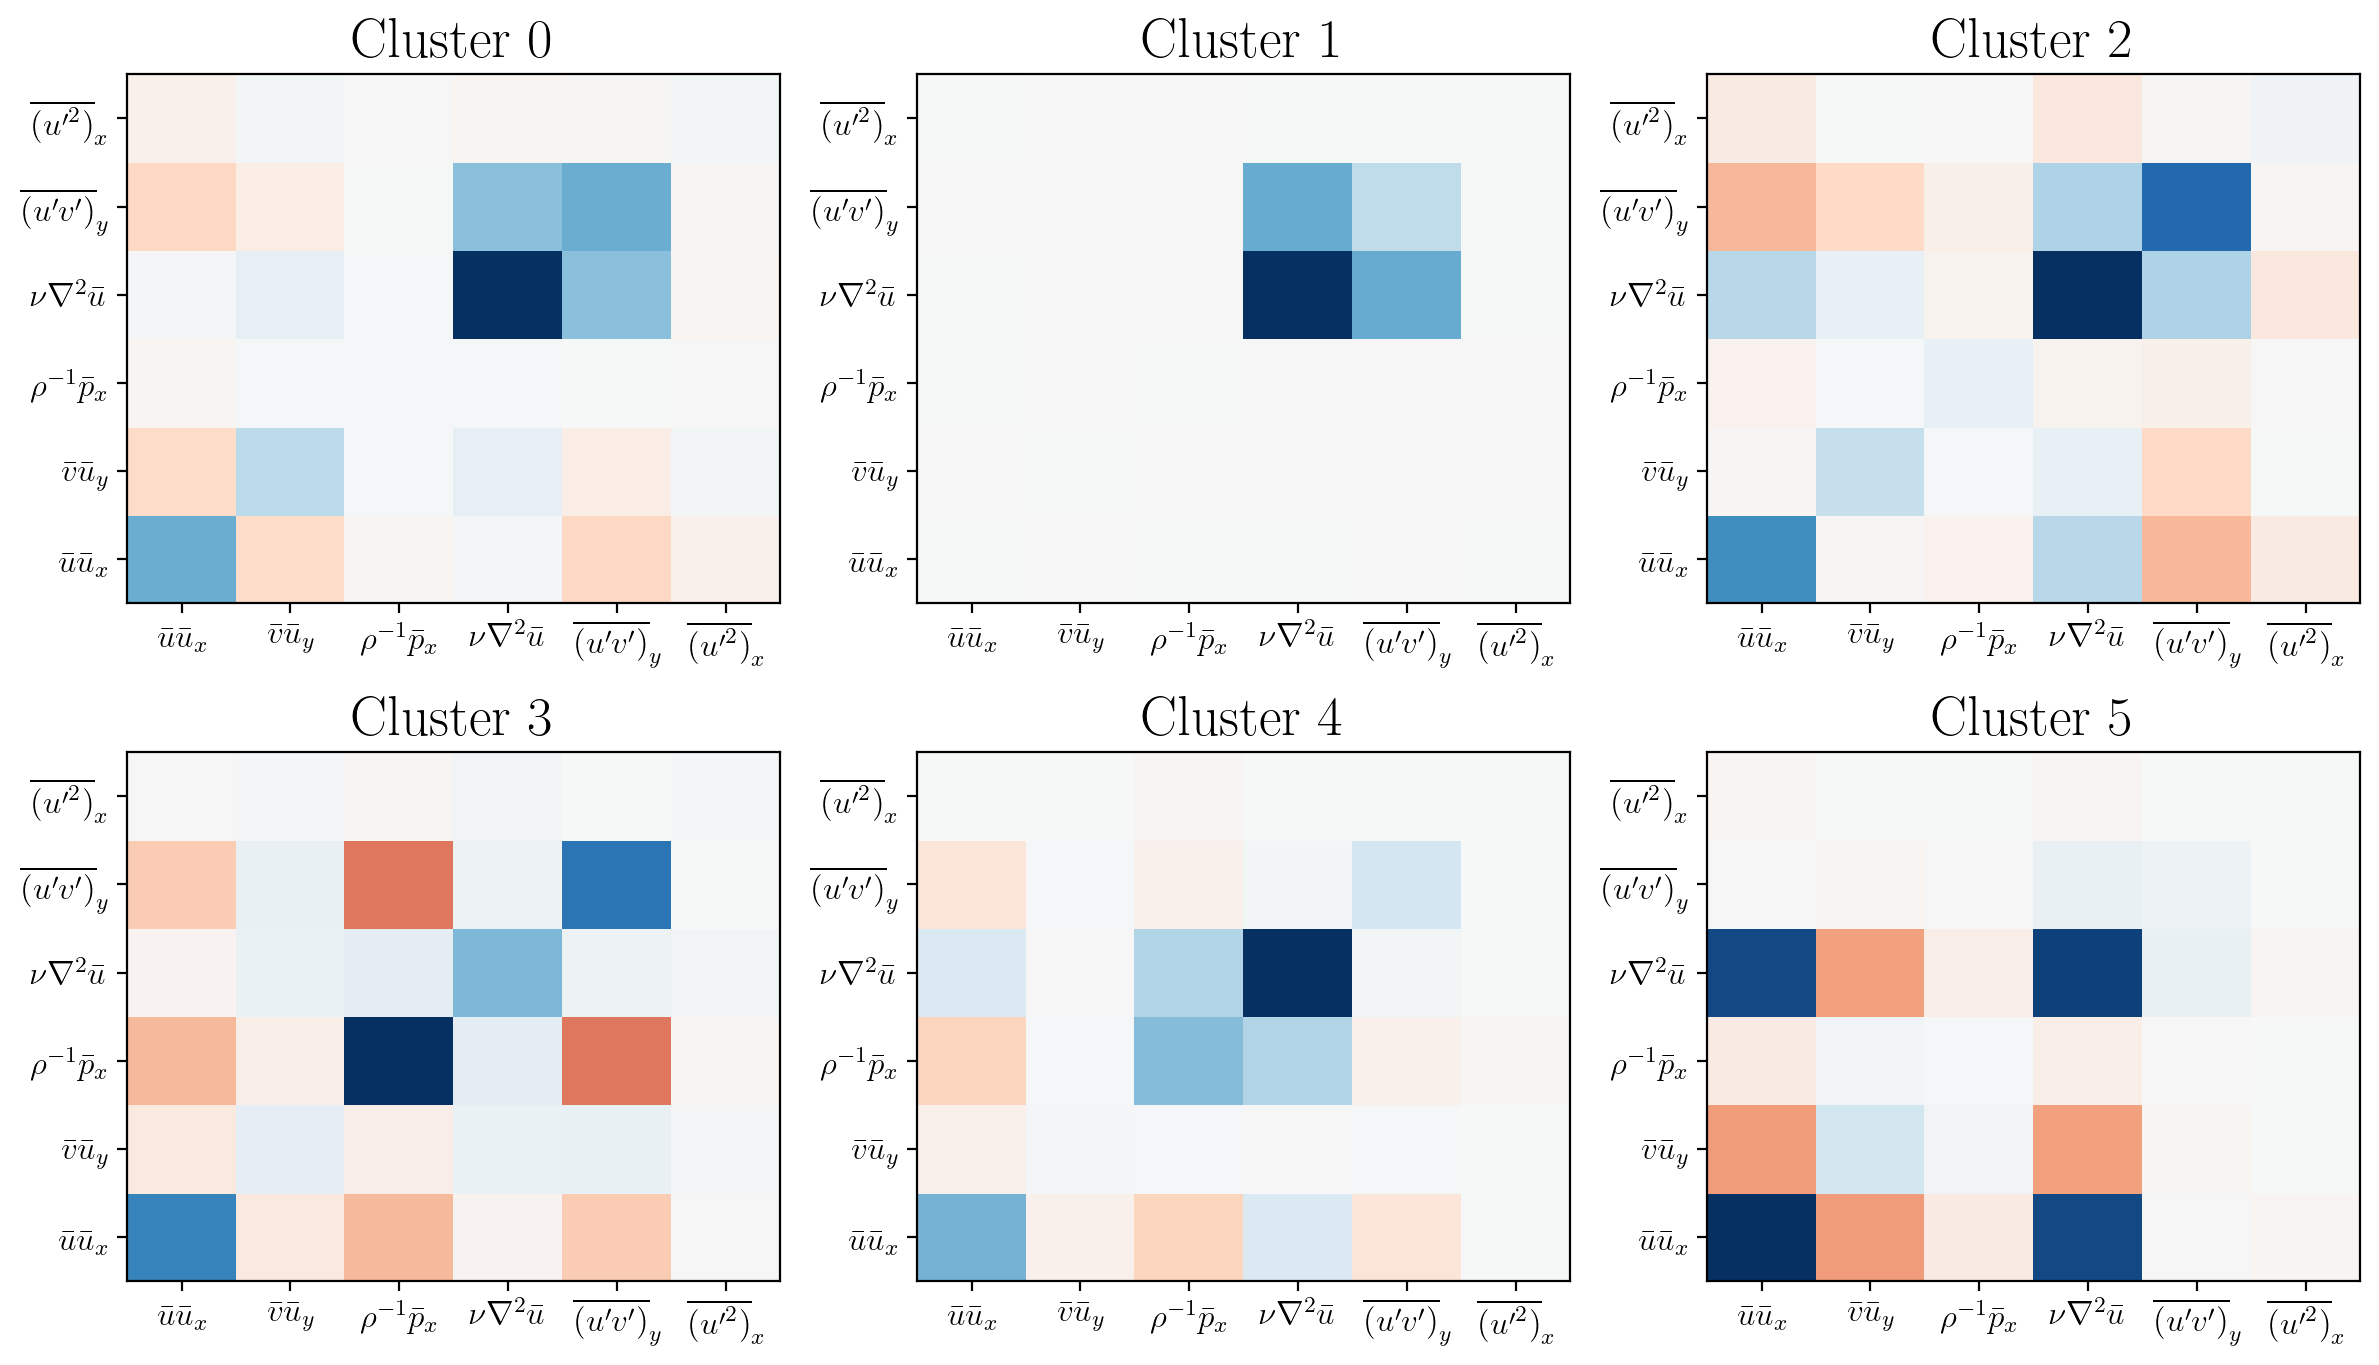

In [13]:
# Plot covariance matrices for each GMM cluster
pf.plot_cov_mat(covs, nfeatures, nc, "Other")

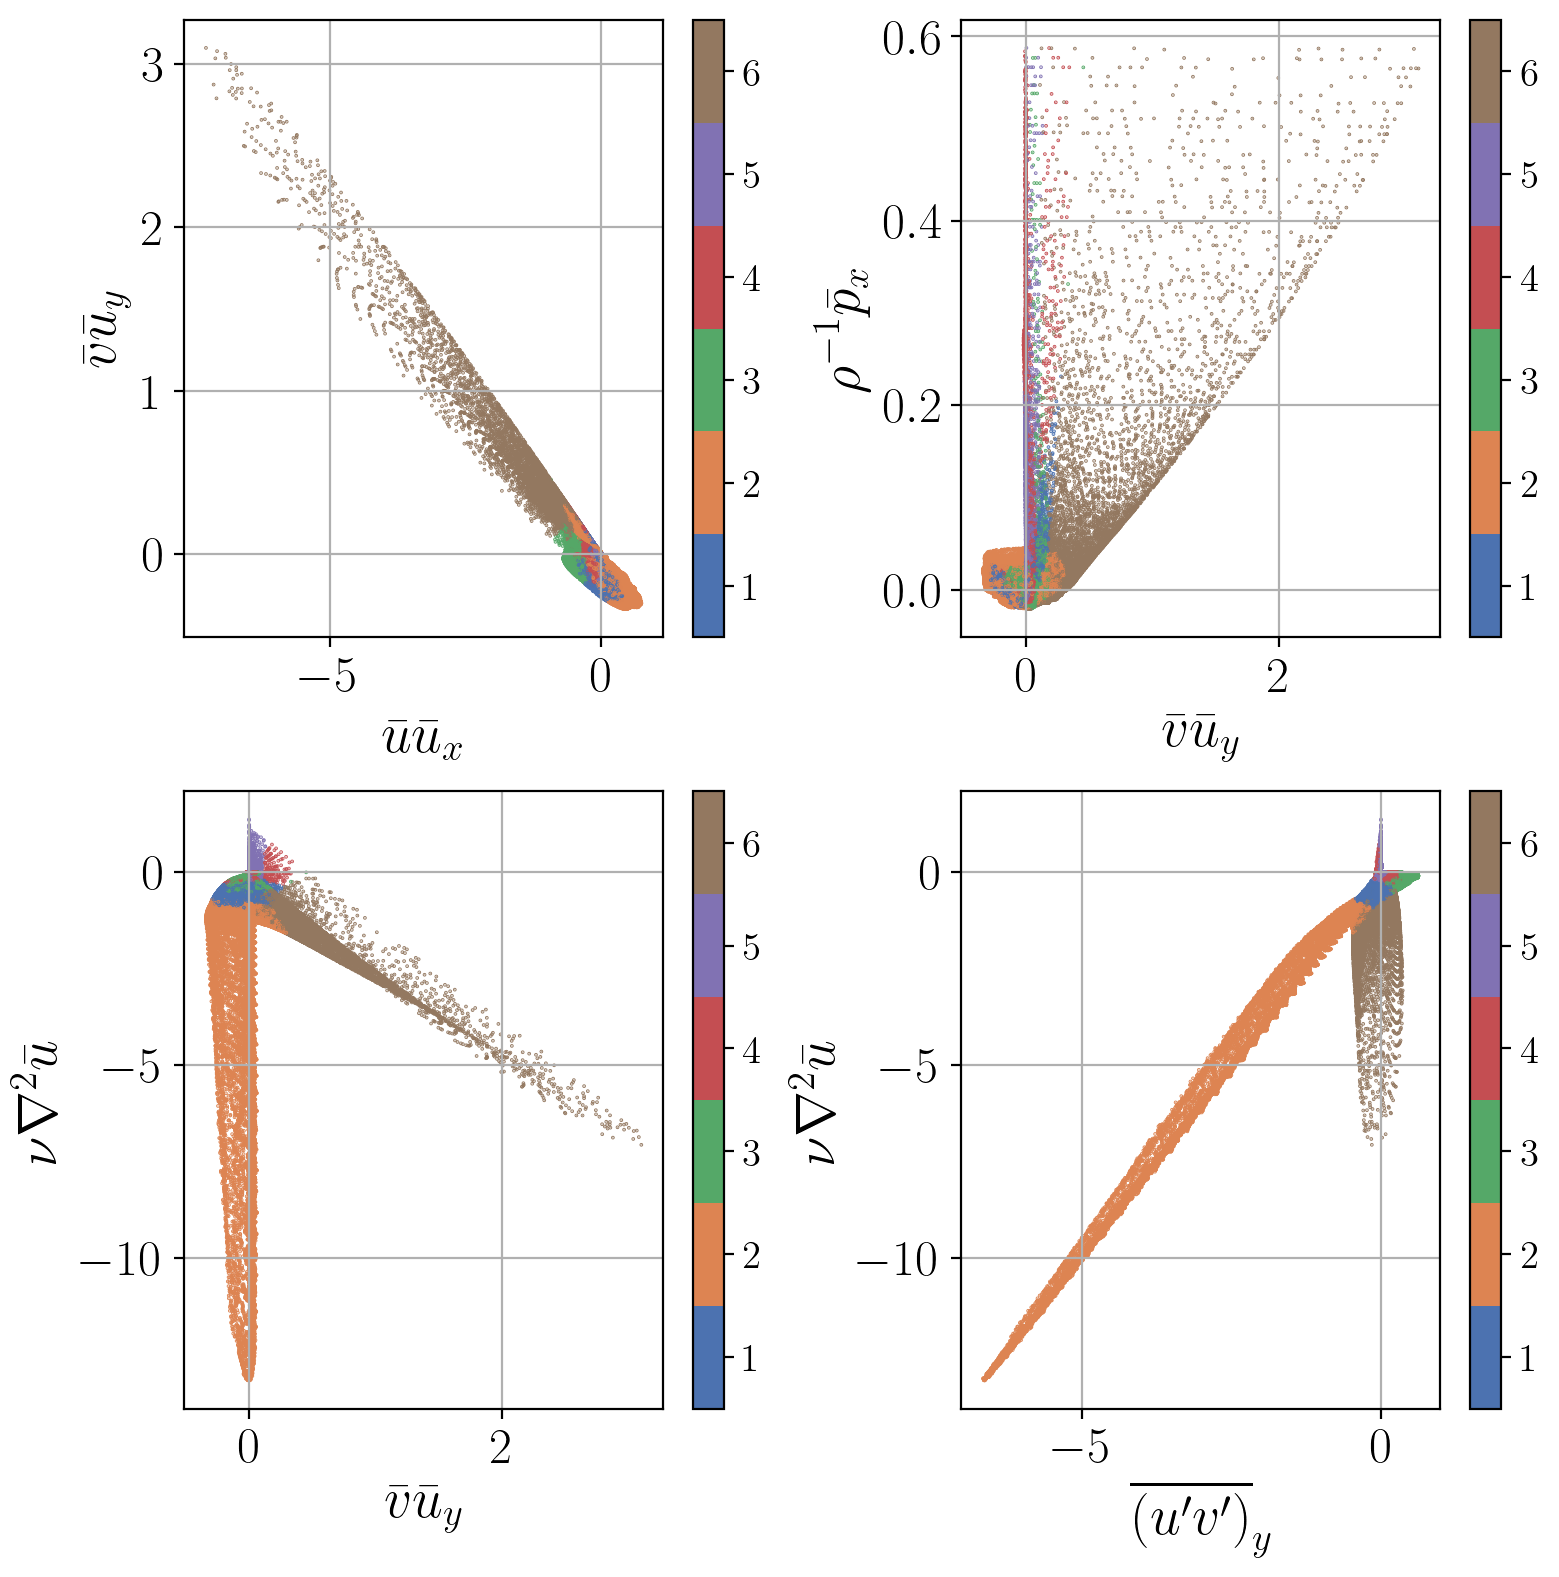

In [14]:
# Visualize GMM clustering with 2D views of equation space

cluster_idx = model.predict(features[mask, :]) + 1
clim = [0.5, cm.N - 0.5]
bounds = np.arange(0.5, nc + 1.5)

pf.plot_clustering_2d_eq_space(features[mask, :], cluster_idx, nc)

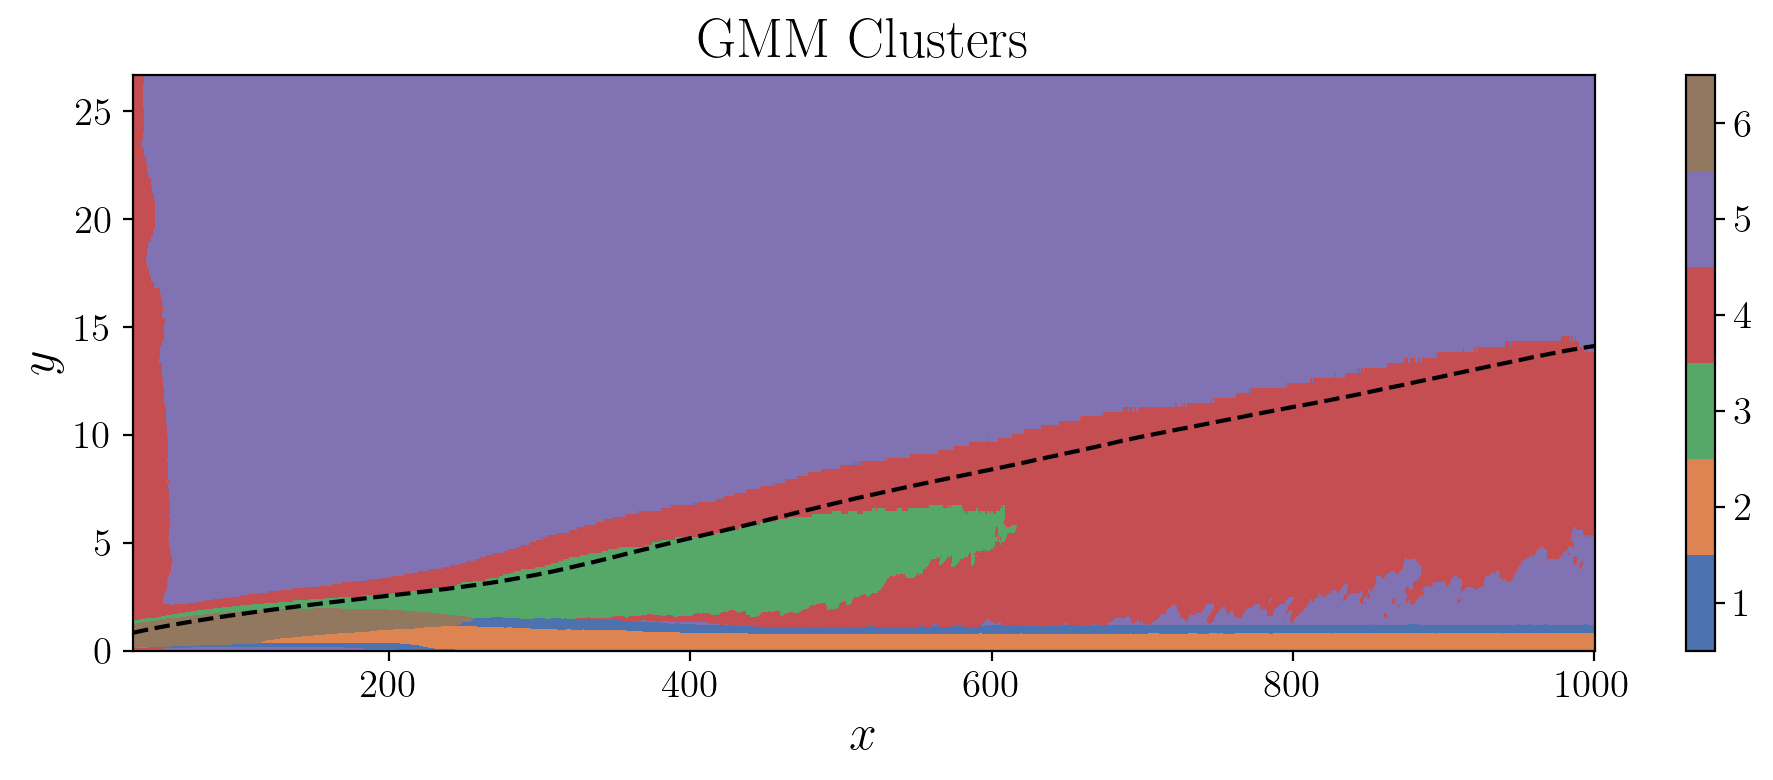

In [15]:
# Assign points in space to each cluster
cluster_idx = model.predict(features)
clustermap = np.reshape(cluster_idx, [ny, nx], order="F")

# Visualize the clustering in space
pf.plot_clustering_space(clustermap, x, y, X, Y, nx, ny, nc, u, U_inf)

## b. Sparce Principal Component Analysis (SPCA) dimensionality reduction

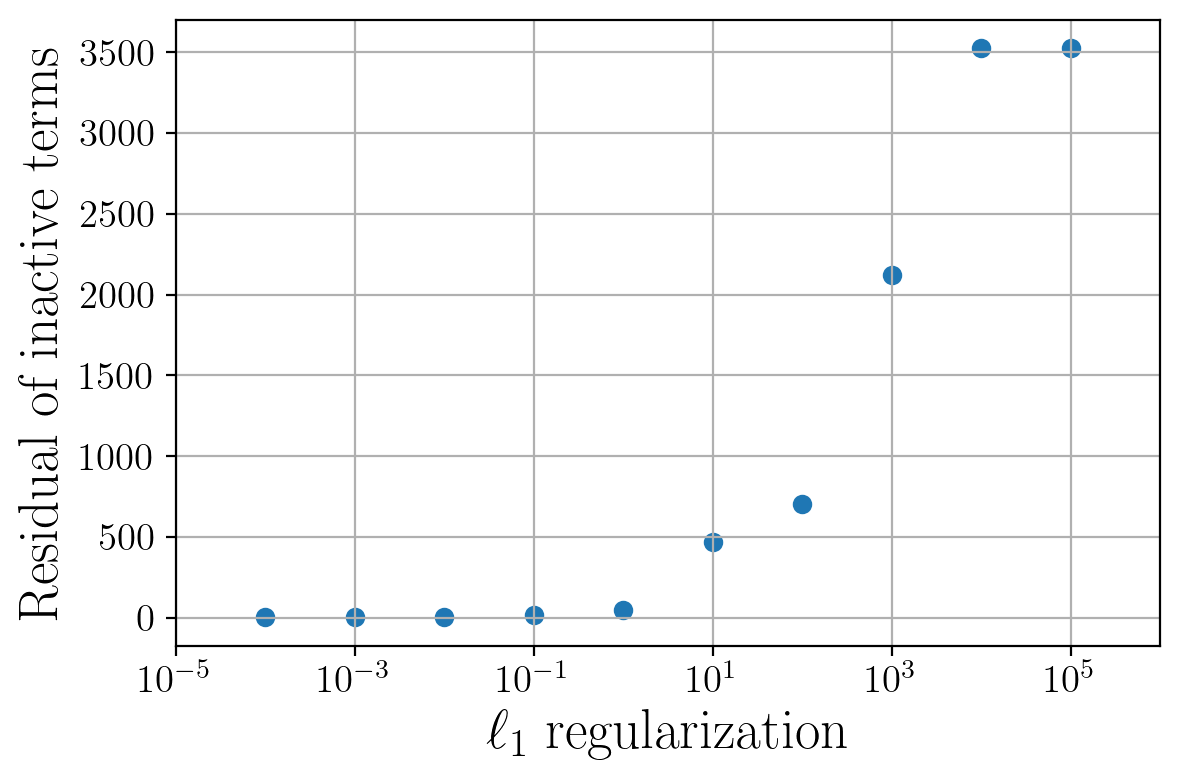

In [16]:
# Sparse PCA to identify directions of nonzero variance in each cluster

alphas = [1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1e3, 1e4, 1e5]
err = np.zeros([len(alphas)])
sparsity = np.zeros([len(alphas)])

for k in range(len(alphas)):
    for i in range(nc):
        # Identify points in the field corresponding to each cluster
        feature_idx = np.nonzero(cluster_idx == i)[0]
        cluster_features = features[feature_idx, :]

        # Conduct Sparse PCA
        spca = SparsePCA(
            n_components=1, alpha=alphas[k], random_state=seed
        )  # normalize_components=True
        spca.fit(cluster_features)

        # Identify active and terms
        active_terms = np.nonzero(spca.components_[0])[0]
        inactive_terms = [feat for feat in range(nfeatures) if feat not in active_terms]

        # Calculate the error, as the sum of the norms of the inactive terms
        err[k] += np.linalg.norm(cluster_features[:, inactive_terms])

pf.plot_spca_residuals(alphas, err)

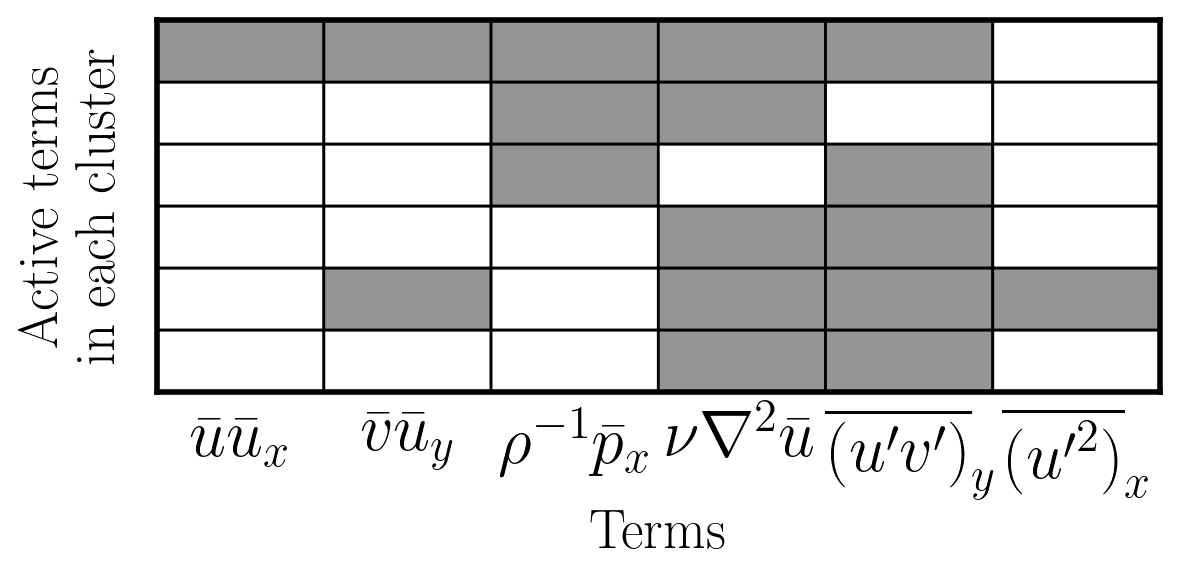

In [34]:
# Get the active terms for each cluster for optimal alpha

alpha_opt = 10  # Optimal alpha value

spca_model = np.zeros([nc, nfeatures])  # Store the active terms for each cluster

for i in range(nc):
    feature_idx = np.nonzero(cluster_idx == i)[0]
    cluster_features = features[feature_idx, :]

    spca = SparsePCA(
        n_components=1, alpha=alpha_opt, random_state=seed
    )  # normalize_components=True
    spca.fit(cluster_features)

    active_terms = np.nonzero(spca.components_[0])[0]
    if len(active_terms) > 0:
        spca_model[i, active_terms] = 1  # Set the active terms to 1

# Plot the active terms in each cluster
pf.plot_active_terms(spca_model, labels)

## c. Resulting Final Dominant Balance Models

In [18]:
# Identify clusters with identical balance models
balance_models, model_index = np.unique(spca_model, axis=0, return_inverse=True)
nmodels = balance_models.shape[0]

# Make new cluster_idx based on the unique SPCA balance model
balance_idx = np.array([model_index[i] for i in cluster_idx])
balancemap = np.reshape(balance_idx, [ny, nx], order="F")

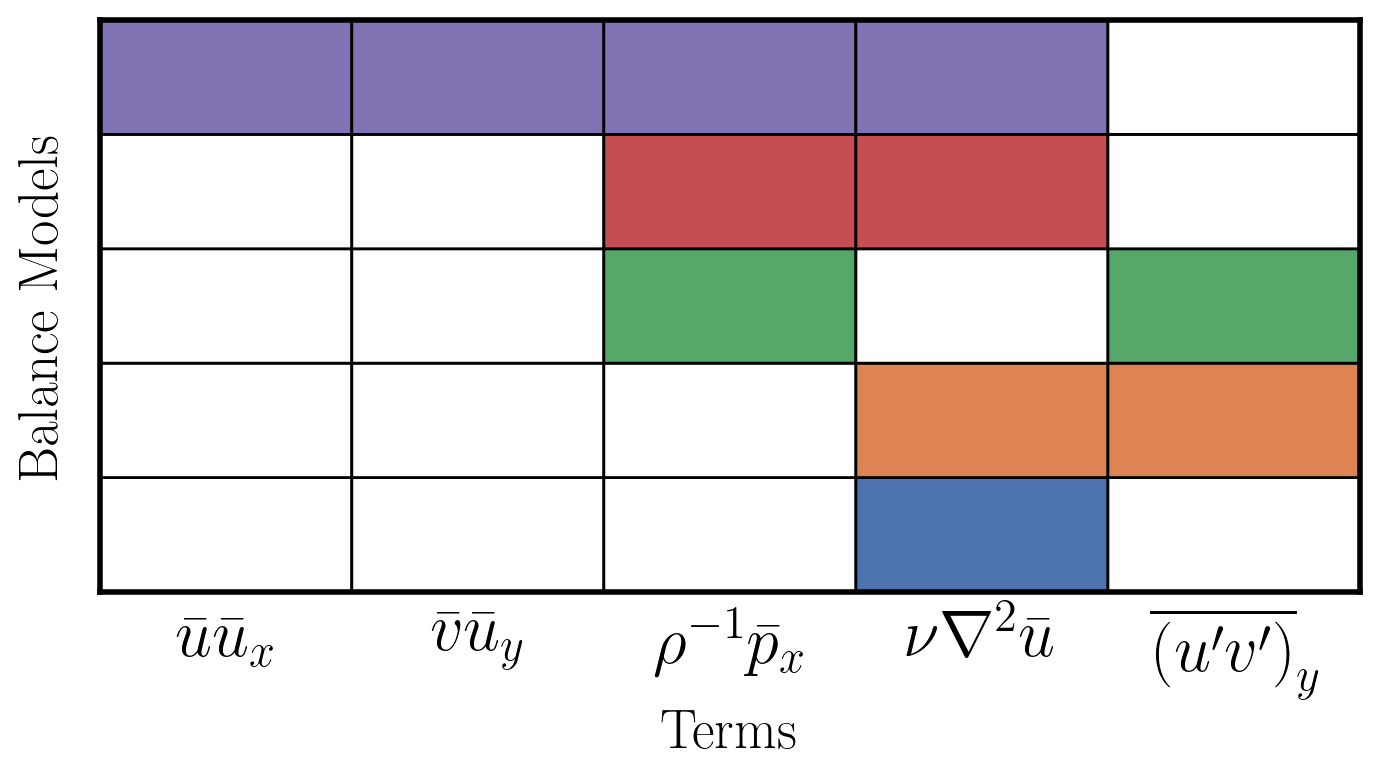

In [19]:
# Plot a grid with active terms in each cluster
gridmap = balance_models.copy()
gridmask = gridmap == 0
gridmap = (
    gridmap.T * np.arange(nmodels)
).T + 1  # Scale map so that active terms can be color-coded
gridmap[gridmask] = 0

# Delete zero terms
grid_mask = np.nonzero(np.all(gridmap == 0, axis=0))[0]
gridmap = np.delete(gridmap, grid_mask, axis=1)
grid_labels = np.delete(labels, grid_mask)

pf.plot_balance_models(gridmap, grid_labels)

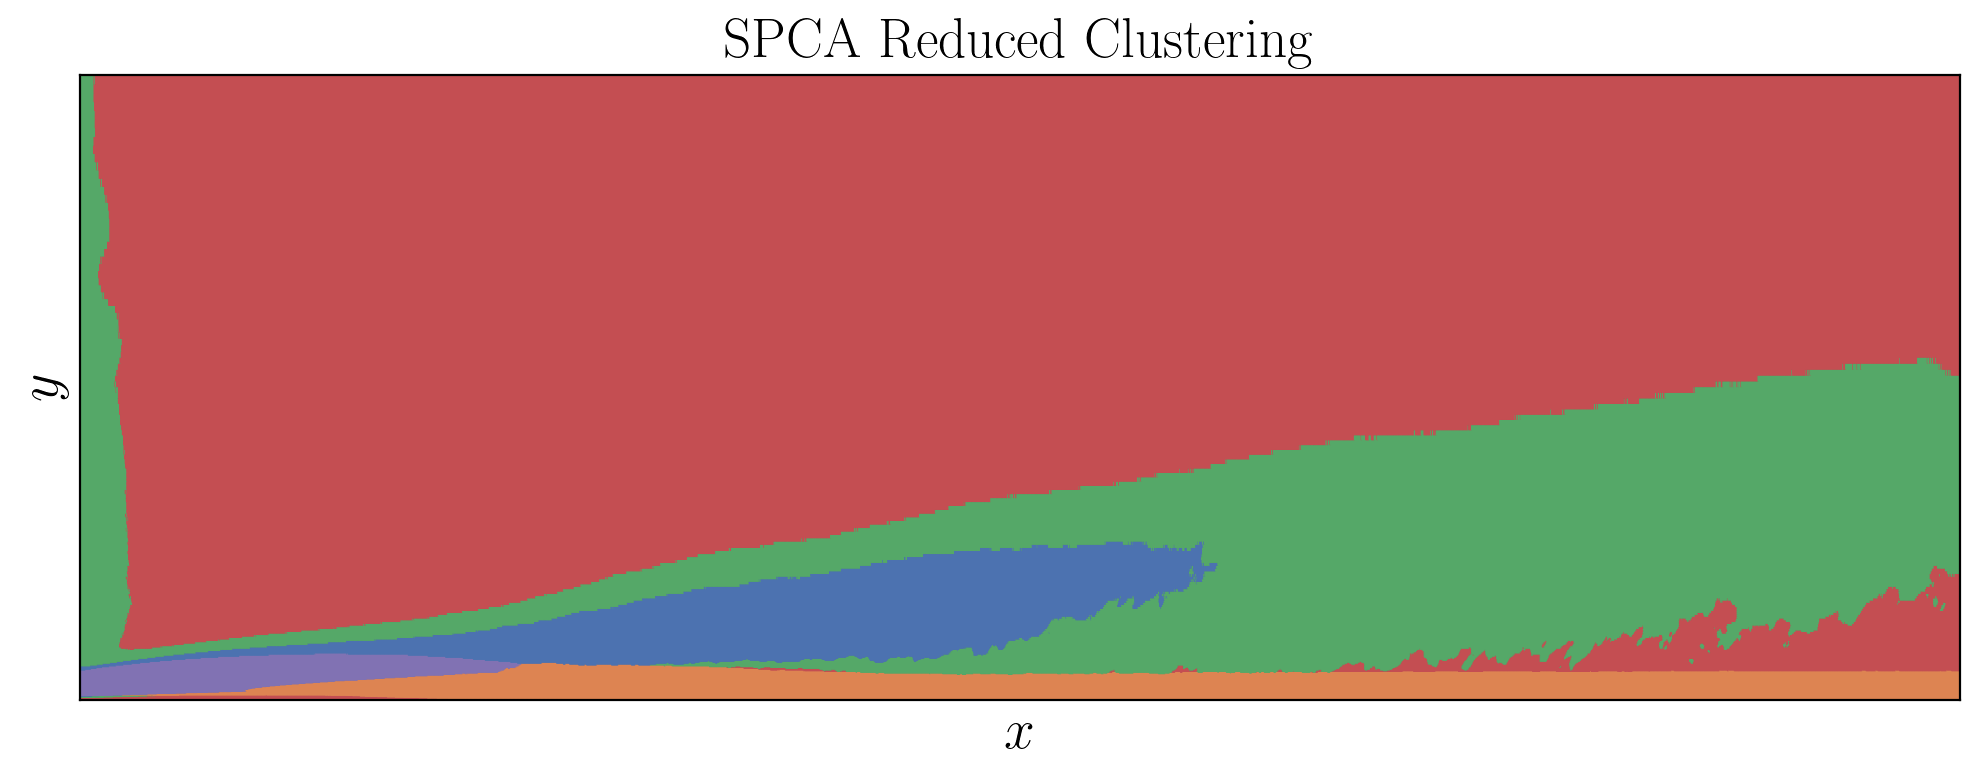

In [20]:
pf.plot_spca_reduced_clustering(x, y, balancemap)

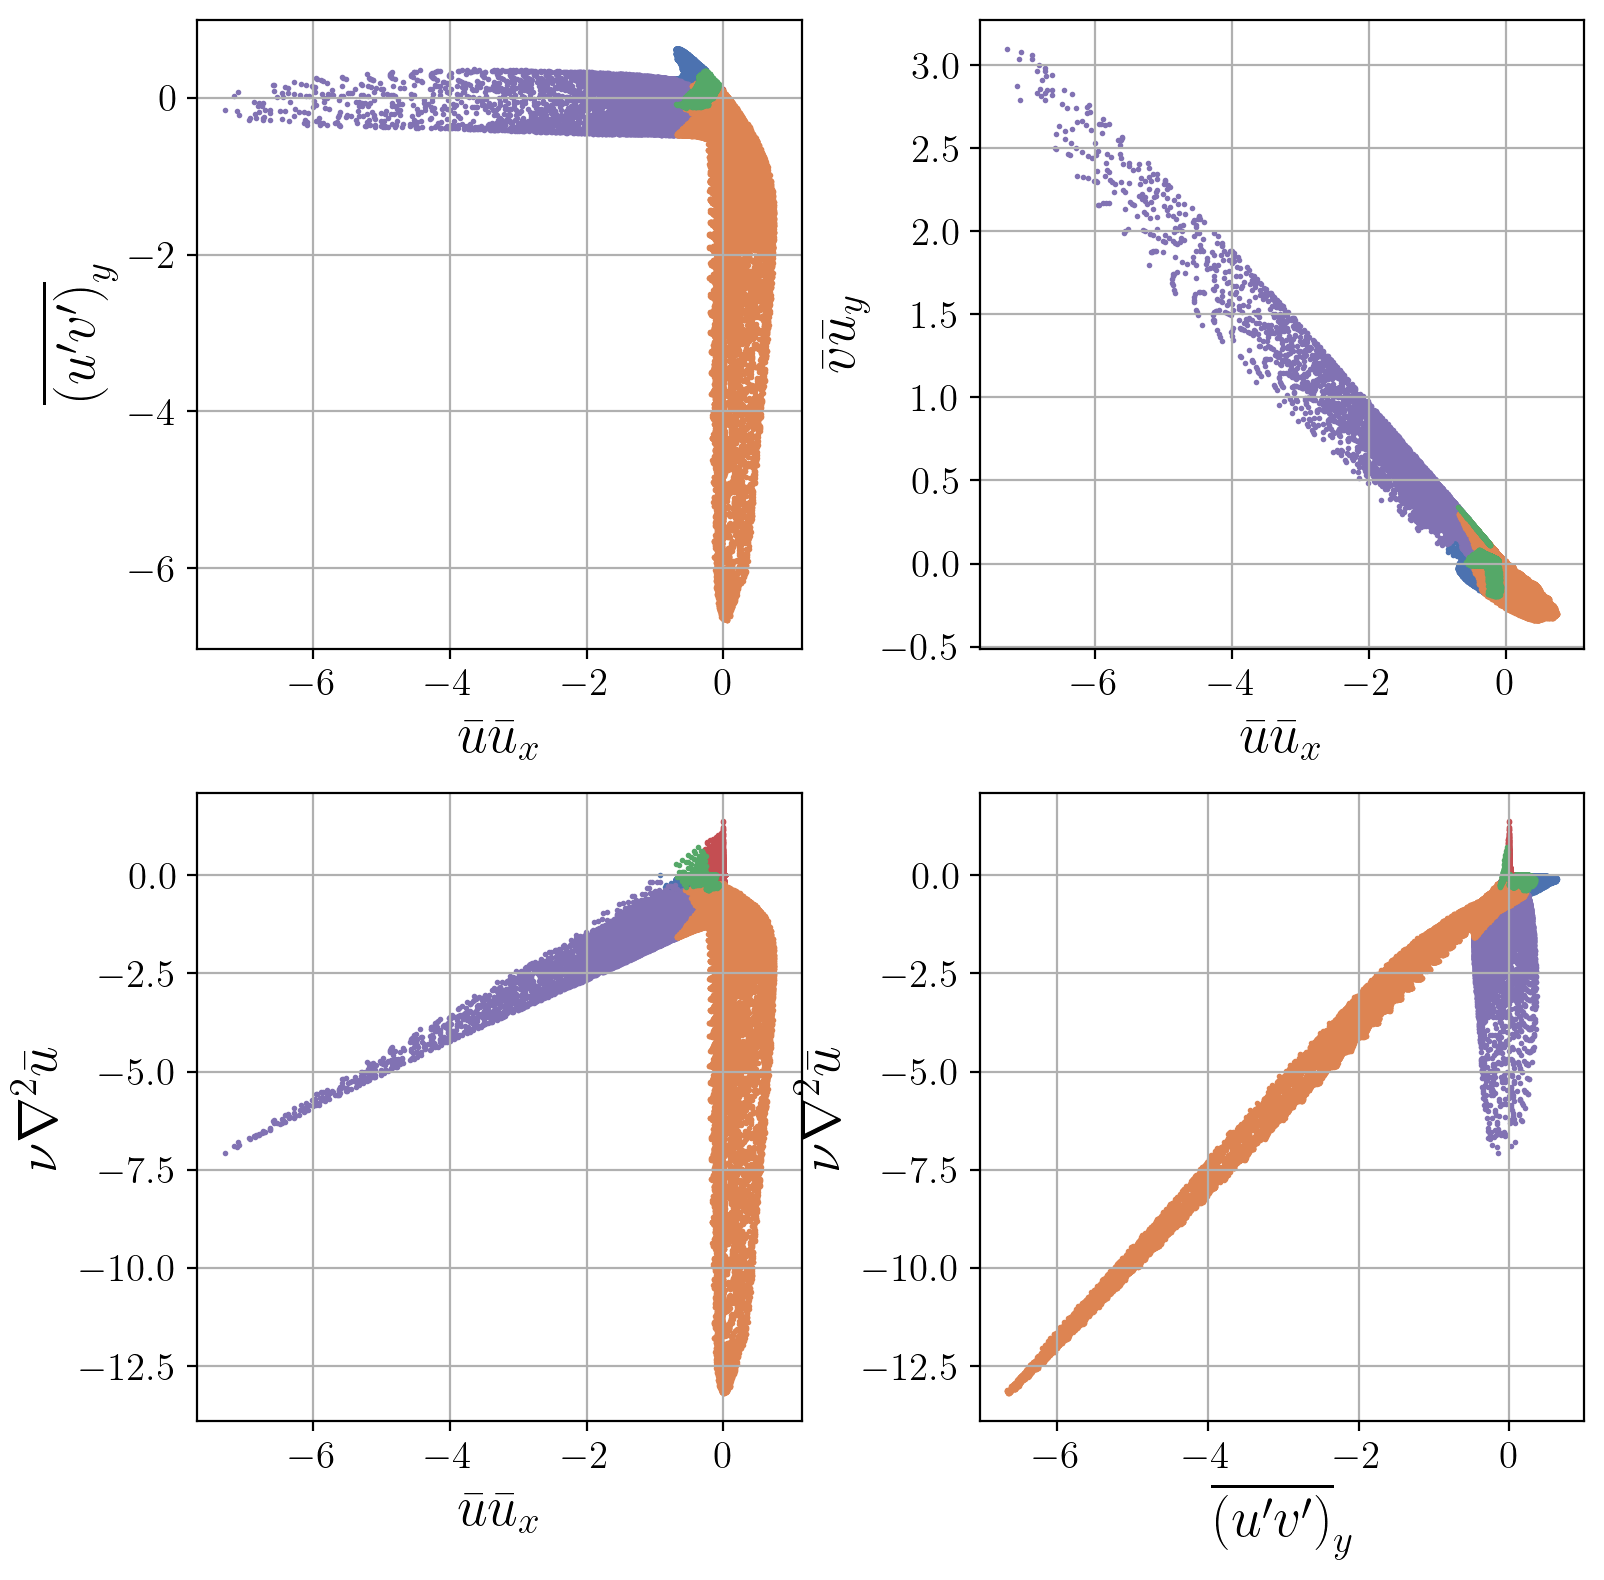

In [21]:
clim = [0.5, cm.N - 0.5]
bounds = np.arange(0.5, nmodels + 1.5)
fontsize = 20
s = 1

# Plot order of the terms for best visibility
order = [3, 0, 4, 1, 2]

# 2D views of feature space
pf.plot_feature_space(features[mask, :], balance_idx[mask])

The weighted K-means algorithm does in fact lead a better discernment of the different dominant balance regimes but with a few inconsistencies. First, regions that probably would not have the same dynamics are clustered together. Taking the 2nd (red) cluster, which has active terms that match the transition region, it groups together the transition region and the viscous sublayer under the same dominant balance model, even though the dominant balance model of the viscous sublayer is identified but for a thinner layer above the red cluster. Additionally part of the laminar inflow region is identified as a separate cluster (purple), however applying SPCA to that cluster returns all terms except $\bar{(u'^{2})_{x}}$ as active, unlike in the validated GMM case.

## Outer Layer Scaling

The length scale of the outer layer should scale with $ \ell \sim x^{4/5} $ (see pg 71 in Holmes, Lumley, Berkooz or pg 638 in Schlichting)

As a rough diagnostic of our balance model, define the outer layer length scale as the wall-normal coordinate where the balance changes from the inertial sublayer to the free-stream (once the transitional region has disappeared).

[0.06853734 0.77648548]


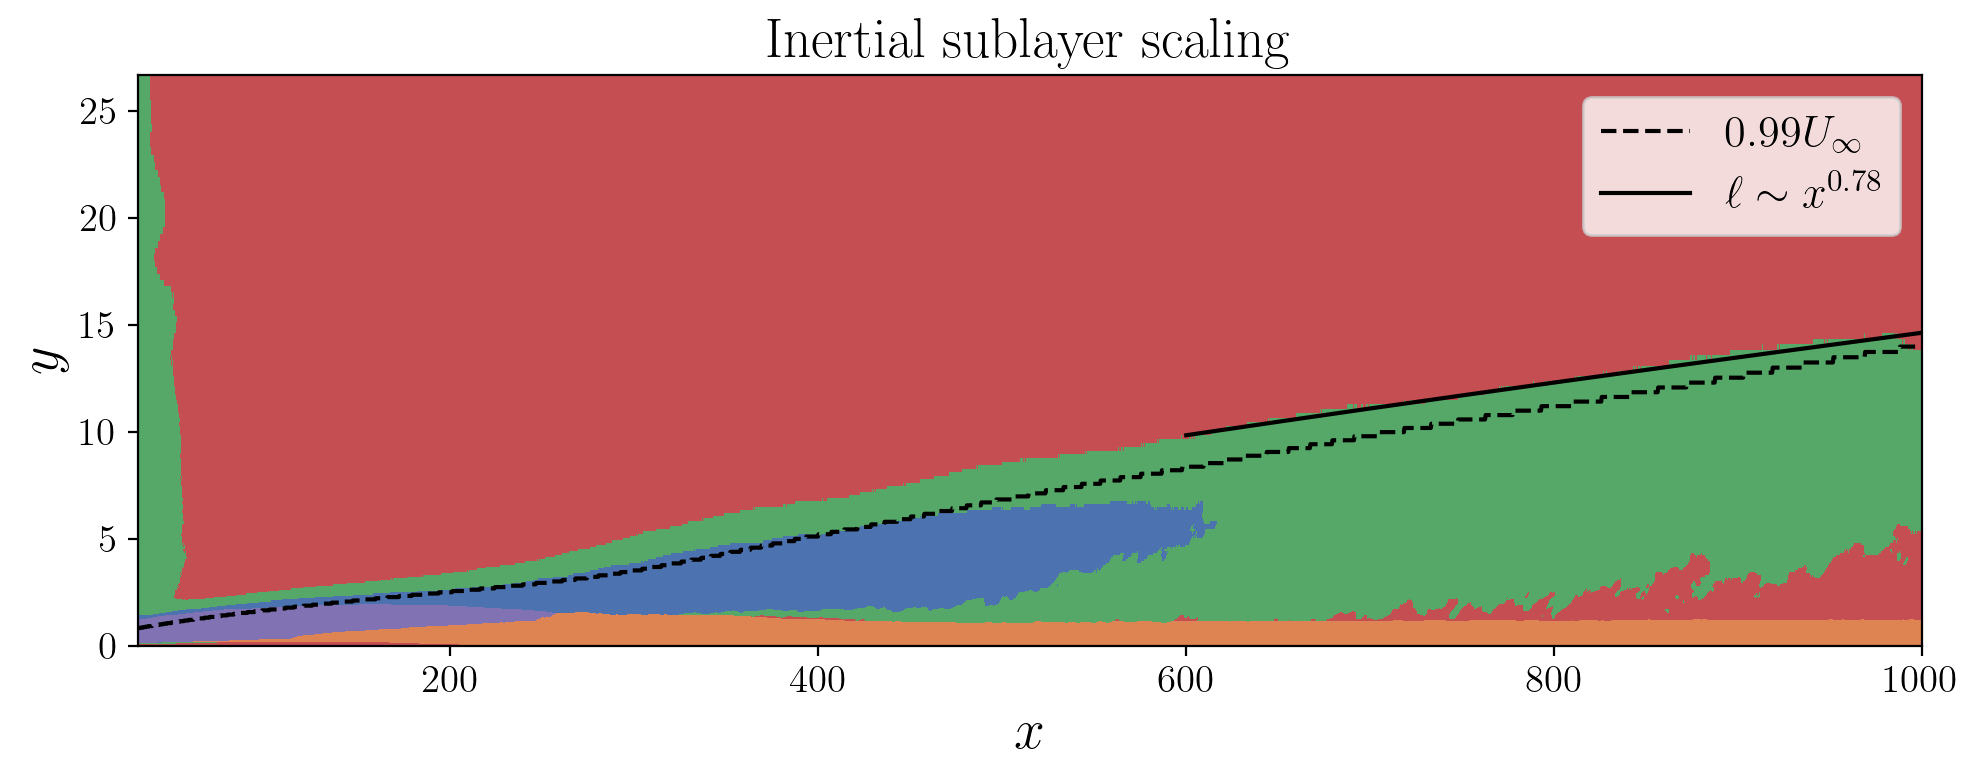

In [22]:
# Define some variables
u_map = np.reshape(u, (ny, nx), order="F")

x_min = 0  # Where inertial balance begins
x_turb = 600  # Where transitional region ends

x_idx = np.nonzero(x > x_min)[0]
x_layer = x[x_idx]

# First, find the upper extent of the inertial sublayer
y_gmm = np.zeros(len(x_idx))
# Loop through wall-normal direction until the balance changes
for i in range(len(x_idx)):
    j = len(y) - 1
    while balancemap[j, x_idx[i]] == 3:
        j -= 1
    y_gmm[i] = y[j]  # Store upper value of inertial balance

# Next, find the 99% of free stream velocity line
delta = np.zeros(len(x))
# Loop until velocity falls past 99% freestream
for i in range(len(x)):
    j = 0
    while u_map[j, i] < 0.99:
        j += 1
    delta[i] = y[j - 1]

# Fit inertial balance to power law
power_law = lambda x, a, b: a * x**b

x_to_fit = x_layer > x_turb  # End of transitional region
p_gmm, cov = curve_fit(power_law, x_layer[x_to_fit], y_gmm[x_to_fit])
gmm_fit = power_law(x_layer, *p_gmm)
print(p_gmm)

# Plot the inertial sublayer scaling
pf.plot_sublayer_scaling(x, y, balancemap, delta, x_layer, gmm_fit, p_gmm, x_to_fit)

## Self-similarity

In the near-wall region (viscous sublayer), we should be able to collapse the profiles using wall units $u^+$, $y^+$. These wall units are defined as: 
- $y^{+}=\frac{y u_{\tau}}{\nu}$, the distance $y$ to the wall, dimensionaless using friction velocity $u_{\tau}$, and kinematic viscosity $\nu$.
- $u^{+}=\frac{u}{u_{\tau}}$, the dimensonless velocity as a function of y.

Here we show that this universality breaks down at approximately the same place where the identified viscous sublayer balance ends. Therefore demonstrating the identified balance models follow fluid dynamics theory.

As shown in the figure above, the wall-normal extent of the sublayer (blue) is approximately constant in the fully-developed turbulent region. We show below that this corresponds to $y^+ \sim 40$.

[Wikipedia](https://en.wikipedia.org/wiki/Law_of_the_wall)

44.44486987887982
43.24269616641768
42.299258407041435
42.61513950083194
41.945711936208205


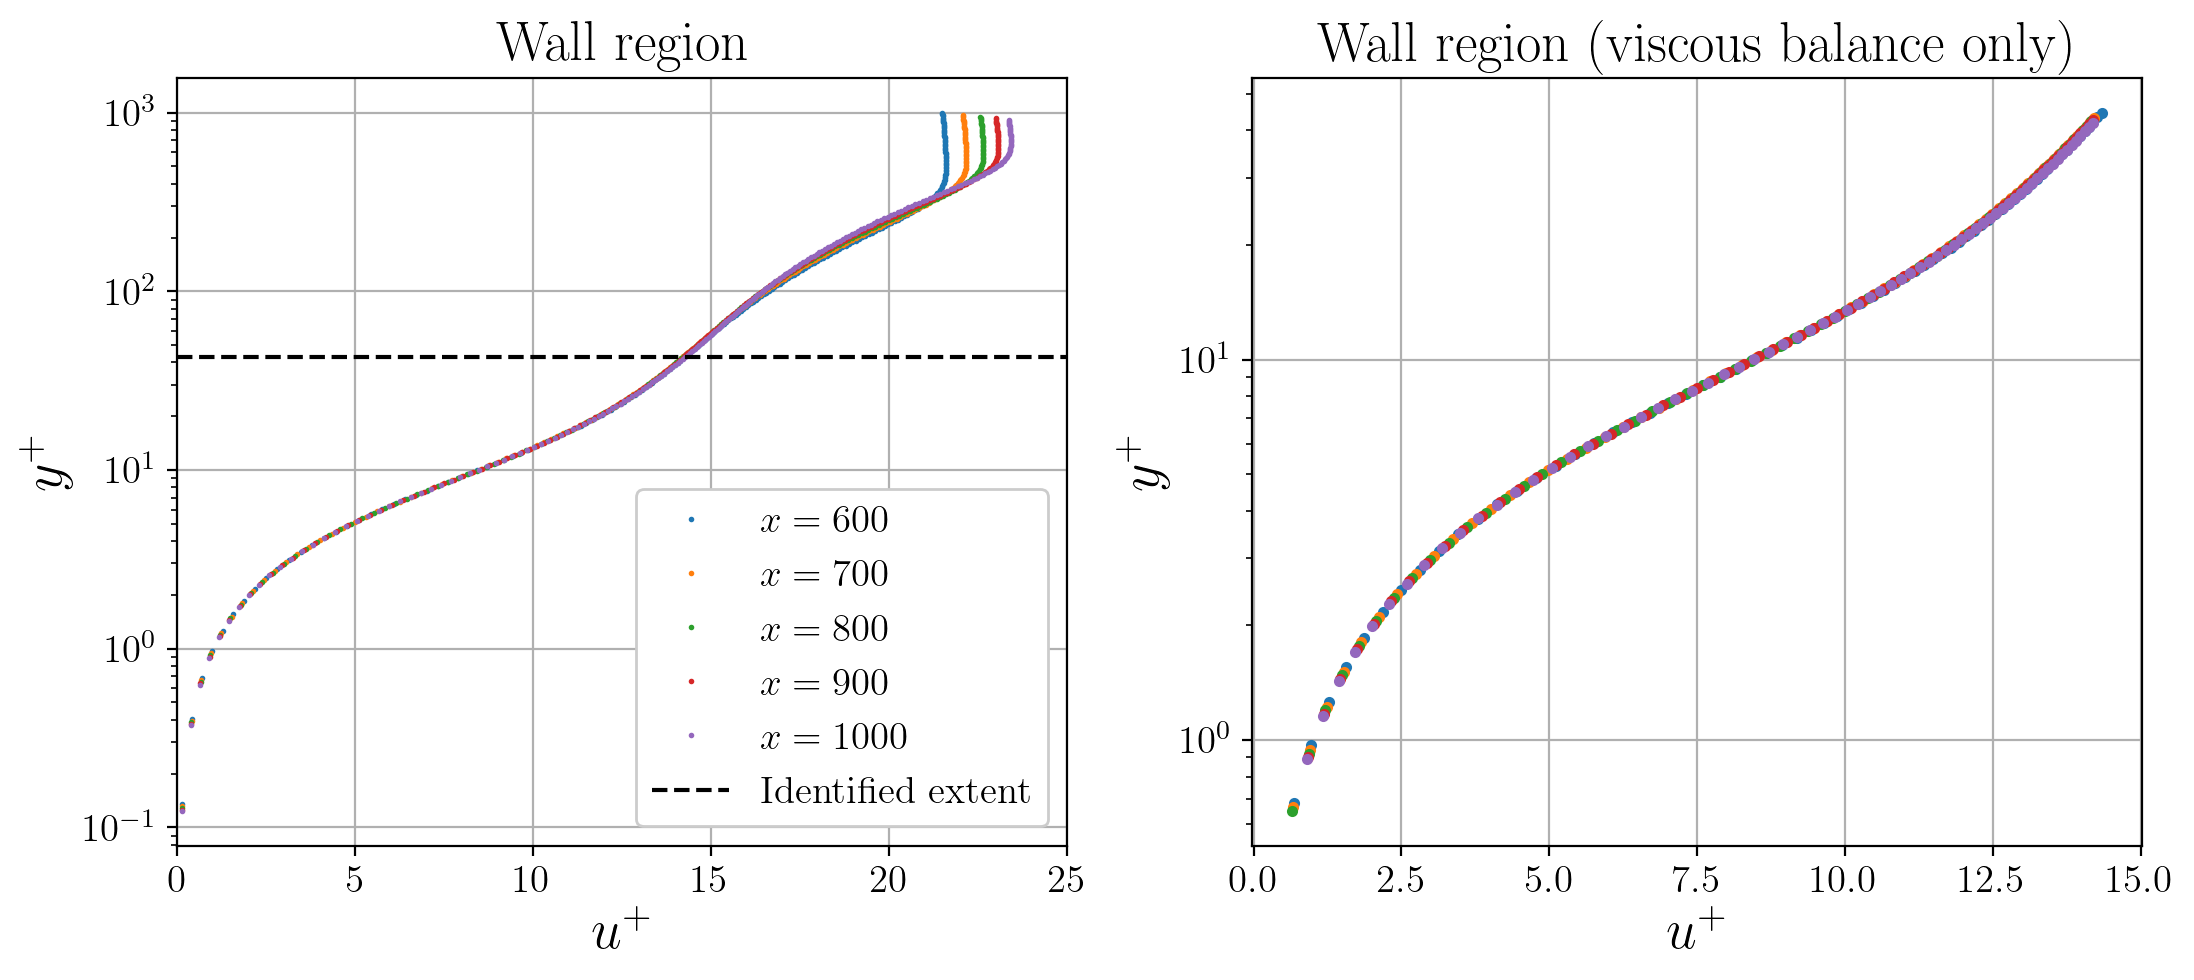

In [23]:
# Compute friction velocity with an estimate of the wall shear stress
u_tau = np.sqrt(nu * uy[::ny])

# Define wall units
y_plus = np.outer(y, u_tau / nu)
u_plus = np.reshape(u, [ny, nx], order="F") / u_tau

# Plot the self-similarity of the flow
pf.plot_self_similarity(x, 1, y_plus, u_plus, balancemap)

## Blasius solution in laminar regime

We also find that there is an inflow region without significant Reynolds stress (purple), which suggests this flow is approximately laminar, until the transitional (orange) region begins around $x\sim 100$.  Before that we would expect the Blasius boundary layer solution to hold.

__Blasius solution:__
$$ \eta = y \sqrt{\frac{U}{2\nu x} }$$
$$ u = U f'(\eta) $$
[Wikipedia](https://en.wikipedia.org/wiki/Blasius_boundary_layer#Blasius_equation_-_first-order_boundary_layer)

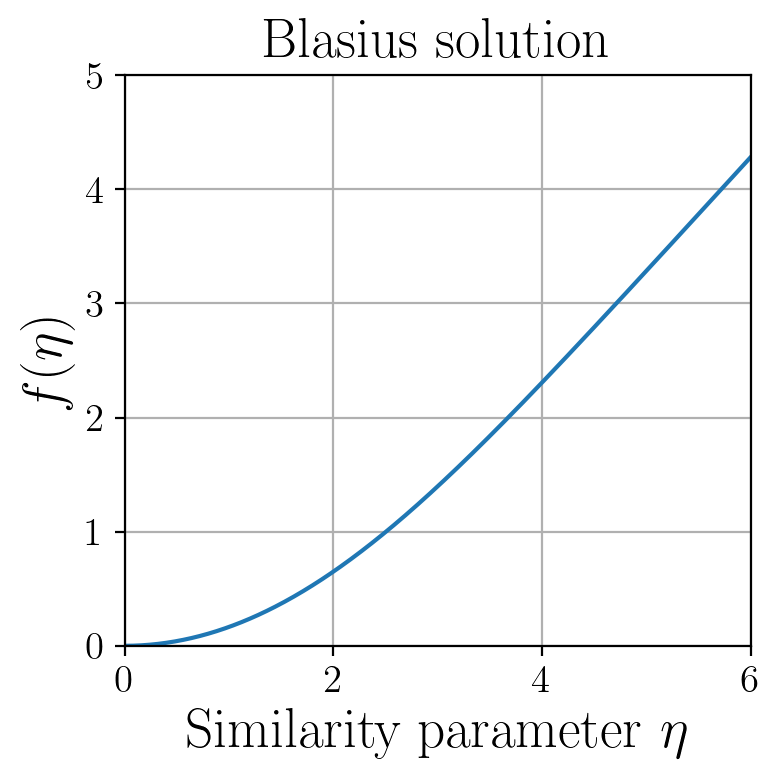

In [24]:
# Solve Blasius equations numerically

# Arbitrary "infinite" upper limit for domain
eta_inf = 200
# Step size
d_eta = 0.01
eta = np.arange(0, eta_inf, d_eta)

# Initial guess for unknown initial condition
F_init = [0, 0, 0]

# Solve root-finding problem for unknown initial condition
opt_res = root(bs.bc_fn, F_init, tol=1e-4)
F0 = [0, 0, opt_res.x[2]]

# Evaluate with resulting initial conditions
f = odeint(lambda y, t: bs.blasius_rhs(y), F0, eta)

pf.plot_blasius_solution(eta, f)

Then we can compare the inflow profile to the Blasius solution (dotted lines indicate region where the transitional balance begins, after $x \sim 150$.  Until that point there is a maximum deviation of about 6% from the Blasius solution.

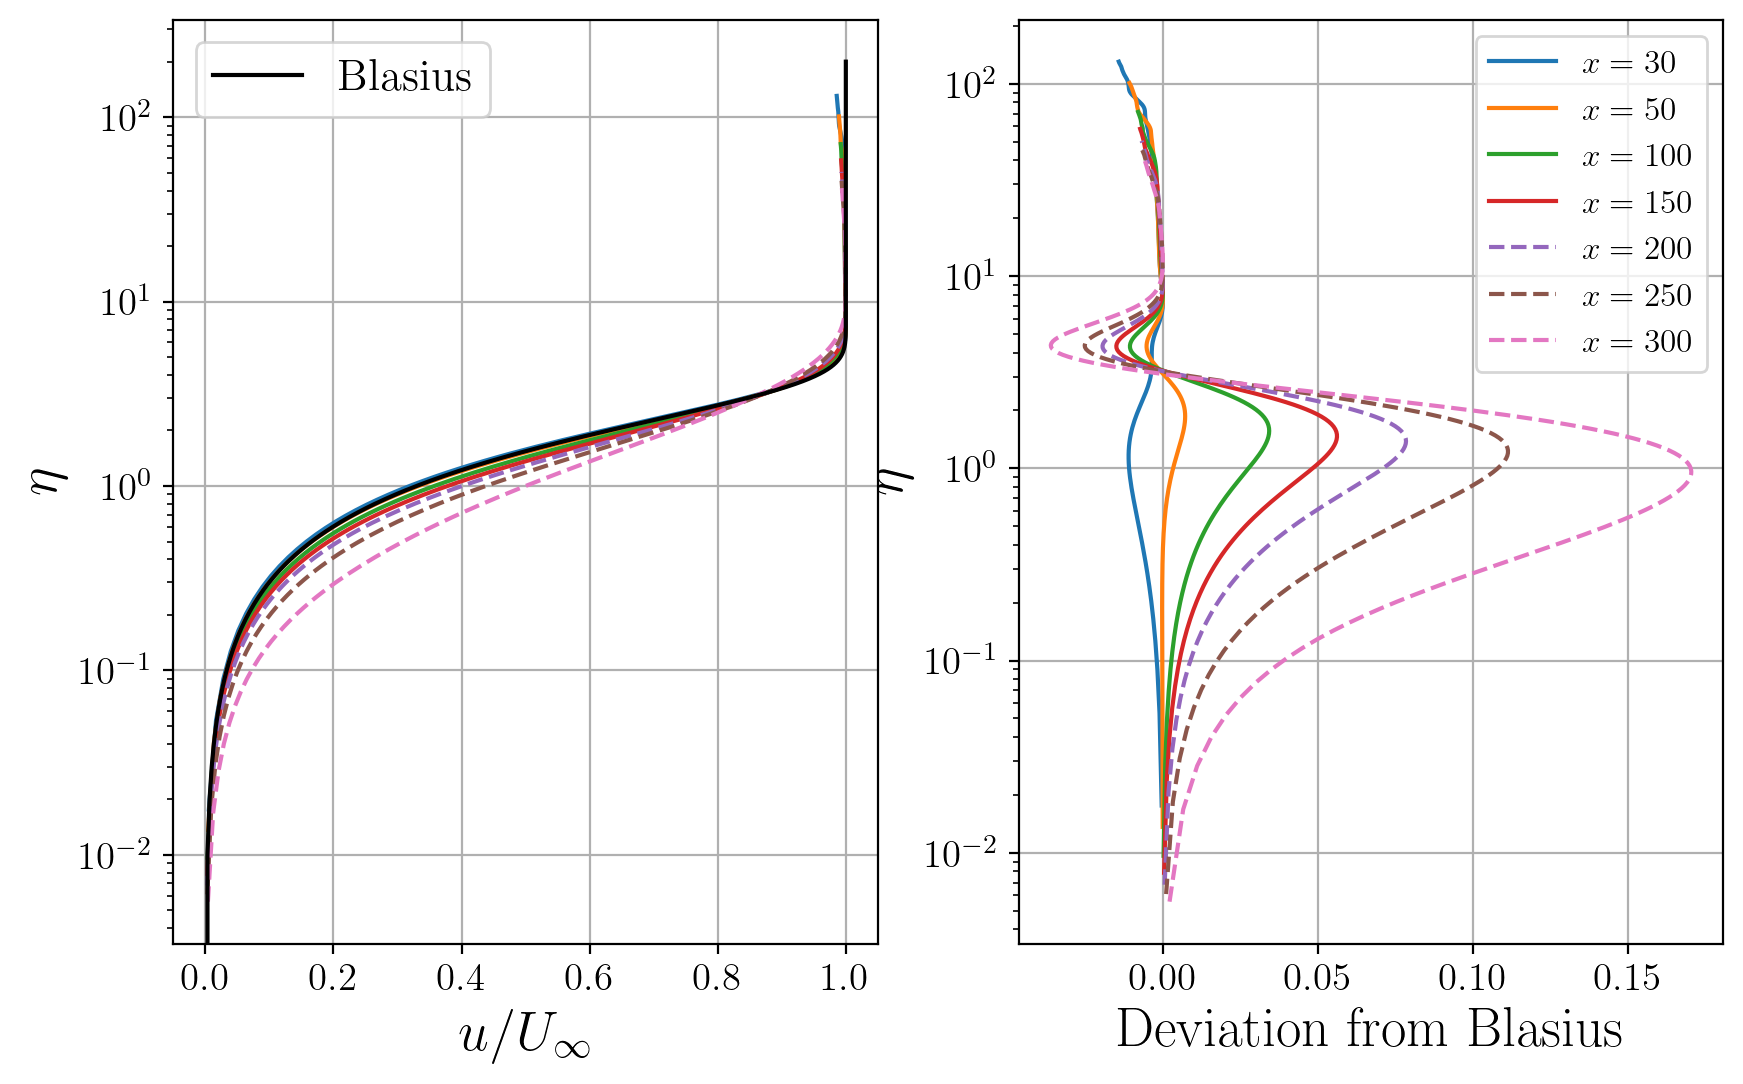

In [25]:
pf.plot_blasius_deviation(x, y, nx, ny, u, eta, f, U_inf, nu)